- now we start with week 6
- from this

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
print(HEAD_PATH)


d:/intern


- number of cores, set this number according to your computer

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product = "btc.usd.td"

- sample period

In [4]:
period = 4096

- get all of the days

In [6]:
import os
good_night_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
good_night_list.sort()
good_night_list[:10]

['d:/intern/pkl tick/btc.usd.td/2017-06-17.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-18.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-19.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-20.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-21.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-22.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-23.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-24.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-25.pkl',
 'd:/intern/pkl tick/btc.usd.td/2017-06-26.pkl']

In [7]:
night_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
len(night_list)
## 1059

1059

In [10]:
good_night_files = np.array([x[-14:] for x in good_night_list])

In [11]:
good_night_files

array(['2017-06-17.pkl', '2017-06-18.pkl', '2017-06-19.pkl', ...,
       '2020-05-20.pkl', '2020-05-21.pkl', '2020-05-22.pkl'], dtype='<U14')

In [46]:
date_str = [n[0:10] for n in good_night_files]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [68]:
train_sample = good_night_files<"2018"
test_sample = good_night_files>"2018"

- let's begin with week 6

- this week we focus on portfolio optimization which gives weights to each strategy


- we have got several signals and each signals have several strategies right now
- let's put them together now


- we can write a function to generage signal backtesting result

- first we create a directory to save the signal backtesting result

In [69]:
os.makedirs(HEAD_PATH+"/signal stat", exist_ok=True)
os.makedirs(HEAD_PATH+"/signal stat/"+product, exist_ok=True)

- then we can write a function to perform the job

In [70]:
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [207]:
len(signal_list)

28

In [266]:
import random
## choosen good strategy from training samples and apply them on test samples
def get_chosen_strategy(product, result_dire, save_name, min_pnl=2, min_num=20):
    random.seed(100) ## set some random numbers, so that we can select different portfolio for each time， 
    ## because if we choose all of them then the total number would be too large
    os.makedirs(HEAD_PATH+"/"+save_name, exist_ok=True)
    for dire in ["trend"]: ## including trend and reversal stratgies
        chosen_strategy = dict() ## final chosen set
        pnl_mat = None ## chosen pnl of all strategies
        spread = product_info[product]["spread"]  ## bid-ask spread of the product
        train_stat = None ## train result
        test_stat = None ## test result
        for y in signal_list: ## iterate over the signal list
            result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+y+".pkl")[dire+".signal.stat"]
            if "train.stat" in result.keys():
                train_stat = result["train.stat"]
                test_stat = result["test.stat"]
                avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean() ## use rolling mean of 3 results to avoid outlier
                avg_pnl.fillna(0, inplace=True)
                good_strat = (avg_pnl>=min_pnl) & (train_stat["final.result"]["avg.pnl"]>=min_pnl)  & (train_stat["final.result"]["num"]>=min_num)
                if sum(good_strat)==0: ## no good strategies 
                    continue;
                elif sum(good_strat)<=5: ## too few good strategies
                    chosen_strategy[y] = good_strat
                elif sum(good_strat)>5: ## too many good strategies
                    chosen =np.random.choice(sum(good_strat), 5, replace=False) 
                    ## just select 1 of them randomly, because for mean-variance we could not handle too many columns
                    #good_strat = np.array(np.where(good_strat))[0,chosen]
                    good_strat = chosen
                    chosen_strategy[y] = chosen
                if pnl_mat is None:
                    pnl_mat = train_stat["daily.ret"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, train_stat["daily.ret"].loc[:, good_strat].values))
        save((chosen_strategy, pnl_mat), HEAD_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl")

In [267]:
get_chosen_strategy(product, "signal result atr", "chosen_strategy_atr", min_pnl=10, min_num=40)

In [268]:
## get the pnl for test samples
def get_test_mat(pnl_mat):
    for dire in ["trend"]: ## iterate for trend and reverse
        chosen_strategy, train_pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl") ## get training result
        for signal_name in chosen_strategy: ## iterate for all chosen strategies
            result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+signal_name+".pkl")[dire+".signal.stat"]
            test_stat = result["test.stat"]
            good_strat = chosen_strategy[signal_name]
            if sum(good_strat)>0:
                if pnl_mat is None:
                    pnl_mat =  test_stat["daily.ret"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, test_stat["daily.ret"].loc[:, good_strat].values))
    return pnl_mat

In [269]:
## get the pnl for test samples
def get_train_mat(pnl_mat):
    for dire in ["trend"]: ## iterate for trend and reverse
        chosen_strategy, train_pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl") ## get training result
        for signal_name in chosen_strategy: ## iterate for all chosen strategies
            result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+signal_name+".pkl")[dire+".signal.stat"]
            train_stat = result["train.stat"]
            good_strat = chosen_strategy[signal_name]
            if sum(good_strat)>0:
                if pnl_mat is None:
                    pnl_mat =  train_stat["daily.ret"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, train_stat["daily.ret"].loc[:, good_strat].values))
            print(signal_name,np.shape(pnl_mat))
    return pnl_mat

In [383]:
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
pnl_mat = get_train_mat(None)

range.pos.4096 (196, 5)
kdj.k.4096 (196, 9)
kdj.j.4096 (196, 14)


In [384]:
np.shape(pnl_mat)

(196, 14)

In [385]:
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
test_mat = get_test_mat(None)

In [386]:
np.shape(test_mat)

(861, 14)

In [387]:
np.shape(pnl_mat)

(196, 14)

- we know the number of training days is

- and there are 25 good strategies in the training sample


- now we want to get the performance in out-sample sets


- at first we try using the mean-variance optimization model


- we need a function to calculate weight of each strategy for a target mean


- here the meaning of each argument is
- m: vector of average daily pnl
- s: covariance matix of daily pnl
- m.star: target daily pnl, which should be within the range of lowest and highest daily pnl

- now we check how it performs in the test samples

In [388]:
test_mat.shape
## (861, 14)

(861, 14)

- we can get the weighted testing pnl

In [389]:
avg_train_pnl = pnl_mat.mean(axis=1)
avg_train_pnl

array([ 0.00000000e+00,  0.00000000e+00, -3.13507548e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.89109119e-03,  0.00000000e+00,
        1.55774253e-02,  0.00000000e+00, -2.29562856e-02, -5.35714286e-04,
        0.00000000e+00, -5.02895321e-03,  0.00000000e+00,  1.40156399e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.17612507e-02,  0.00000000e+00,  3.31495418e-02,  6.44457330e-02,
        0.00000000e+00,  1.84360334e-05, -1.03650110e-02,  0.00000000e+00,
        5.65473433e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.69995152e-02,  1.85382471e-02,  0.00000000e+00,  0.00000000e+00,
        1.60641984e-02,  0.00000000e+00, -1.92434638e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.60790913e-03,  0.00000000e+00,  0.00000000e+00, -1.33968666e-03,
        0.00000000e+00,  

- we can draw the plot

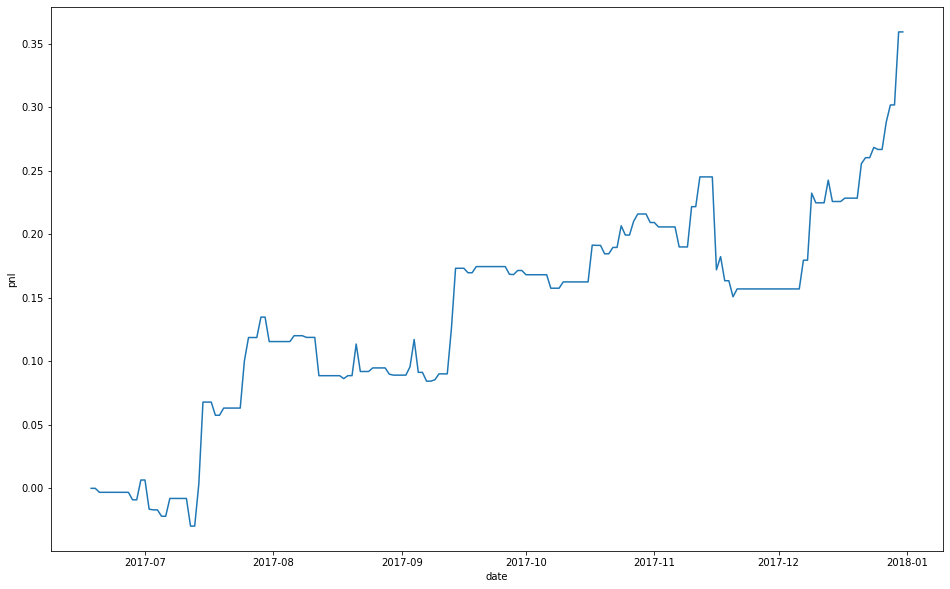

In [390]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], avg_train_pnl.cumsum());

In [391]:
sharpe(avg_train_pnl)
## 2.206416144239459

2.206416144239459

- average testing pnl

In [392]:
avg_test_pnl = test_mat.mean(axis=1)

- and plot the final pnl

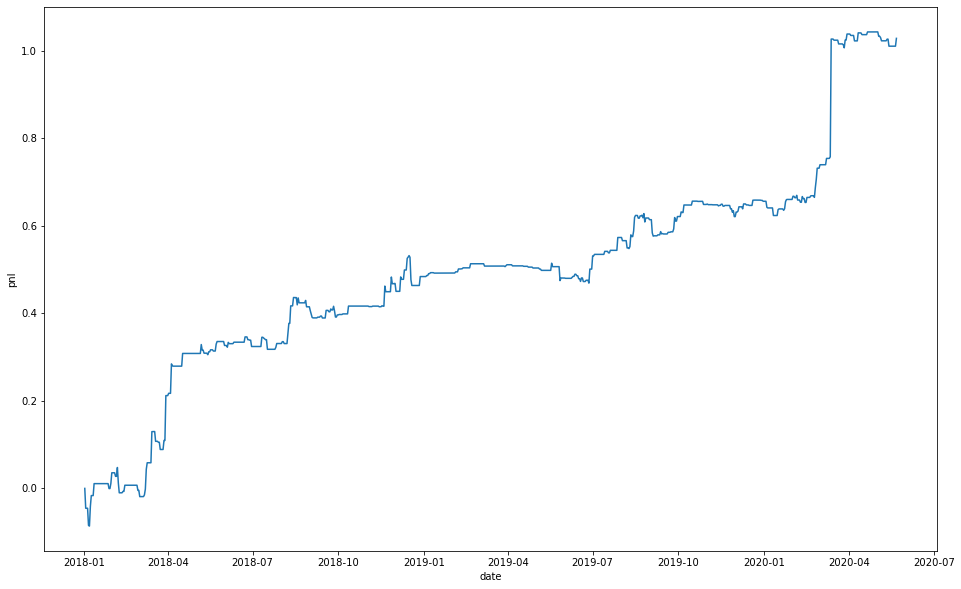

In [393]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][1:], avg_test_pnl.cumsum());

- calculate the sharp ratio

In [394]:
sharpe(avg_test_pnl)
## 1.478678162811324

1.478678162811324

- we can see it's quite good


- so what's the problem of mean-variance optimization
- at first, it overfit the training samples obviously
- secondly, the estimation of covariance matrix nad mean daily pnl have some problem

- at first we try using the mean-variance optimization model


- we need a function to calculate weight of each strategy for a target mean


- here the meaning of each argument is
- m: vector of average daily pnl
- s: covariance matix of daily pnl
- m.star: target daily pnl, which should be within the range of lowest and highest daily pnl

In [395]:
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》

- get daily average pnl of each strategy

In [396]:
mean_return = pnl_mat.mean(axis=0)

- get covariance matrix of each strategy

In [397]:
cov_return = np.cov(pnl_mat, rowvar=False)
n_point = 30
n_strat = pnl_mat.shape[1]
m_grid = np.linspace(min(mean_return), max(mean_return), n_point)
m_grid

# array([-1.55310781e-03, -1.33881096e-03, -1.12451410e-03, -9.10217248e-04,
#        -6.95920394e-04, -4.81623540e-04, -2.67326686e-04, -5.30298313e-05,
#         1.61267023e-04,  3.75563877e-04,  5.89860731e-04,  8.04157586e-04,
#         1.01845444e-03,  1.23275129e-03,  1.44704815e-03,  1.66134500e-03,
#         1.87564186e-03,  2.08993871e-03,  2.30423557e-03,  2.51853242e-03,
#         2.73282927e-03,  2.94712613e-03,  3.16142298e-03,  3.37571984e-03,
#         3.59001669e-03,  3.80431355e-03,  4.01861040e-03,  4.23290725e-03,
#         4.44720411e-03,  4.66150096e-03])

array([-1.23559031e-03, -1.03224233e-03, -8.28894358e-04, -6.25546383e-04,
       -4.22198408e-04, -2.18850434e-04, -1.55024587e-05,  1.87845516e-04,
        3.91193491e-04,  5.94541466e-04,  7.97889441e-04,  1.00123742e-03,
        1.20458539e-03,  1.40793337e-03,  1.61128134e-03,  1.81462931e-03,
        2.01797729e-03,  2.22132526e-03,  2.42467324e-03,  2.62802121e-03,
        2.83136919e-03,  3.03471716e-03,  3.23806514e-03,  3.44141311e-03,
        3.64476109e-03,  3.84810906e-03,  4.05145704e-03,  4.25480501e-03,
        4.45815299e-03,  4.66150096e-03])

In [398]:
import scipy

In [399]:
E,V = scipy.linalg.eigh(cov_return)
np.all(E > 0)
## it's positive defintie

True

In [400]:
cov_grid = np.repeat(np.nan, n_point)
weight_grid = np.zeros((n_strat, n_point))


In [401]:
s_inv = np.linalg.inv(cov_return)
s_inv

# array([[ 1.18233873e+04,  5.54872383e+02, -4.08017786e+02,
#         -2.04712658e+02, -5.09337038e+03,  1.41827289e+02,
#          1.25362867e+04, -3.08845386e+03,  7.74678780e+02,
#         -1.15155466e+04,  4.12720200e+03, -4.69736859e+01,
#          3.94731657e+01, -3.13946187e+03,  2.31469735e+03,
#          5.49934827e+02,  9.81010099e+02,  1.47838718e+03,
#         -1.97630712e+03, -7.58710689e+02],
#        [ 5.54872383e+02,  2.46488625e+04, -2.00547502e+04,
#         -4.42032587e+03,  1.60530604e+04,  1.29375323e+03,
#          1.92814353e+04,  1.87138184e+02,  5.92765100e+02,
#         -1.41985453e+04, -1.19788992e+04,  1.20271792e+04,
#         -4.12526399e+02, -2.35390191e+03,  1.48858120e+03,
#          8.61534818e+02,  1.25407903e+02, -1.52372334e+03,
#         -3.50116511e+03, -1.71904019e+03],
#        [-4.08017786e+02, -2.00547502e+04,  1.91349415e+05,
#         -4.64320465e+04, -1.40419162e+05, -9.76183926e+02,
#         -1.25464931e+04,  1.28900911e+03, -1.34749236e+03,
#          8.30892783e+03,  1.61429351e+04, -2.01640927e+04,
#          1.52511993e+03,  6.50907548e+03, -1.29660274e+03,
#         -3.21375468e+03, -1.05670895e+03,  7.53675674e+03,
#          4.58237657e+03, -4.86743466e+03],
#        [-2.04712658e+02, -4.42032587e+03, -4.64320465e+04,
#          5.84623249e+04, -1.07284372e+04,  7.58772711e+02,
#         -5.76263745e+03, -6.40425879e+02, -2.02553210e+01,
#          4.67198219e+03, -1.33638957e+03, -3.12530379e+02,
#         -5.99837847e+02,  4.01326561e+02, -1.82224417e+03,
#          1.02561147e+03,  6.56674085e+02, -2.18766507e+03,
#          9.98930602e+02,  2.12786841e+03],
#        [-5.09337038e+03,  1.60530604e+04, -1.40419162e+05,
#         -1.07284372e+04,  1.53641090e+05, -1.47406720e+03,
#          1.21973939e+02,  1.47295634e+03,  3.19414023e+02,
#          2.03130212e+03, -1.07380466e+04,  1.46349383e+04,
#         -6.53995326e+02, -5.43105961e+03,  1.82314642e+03,
#          1.61270691e+03, -3.99960182e+01, -4.34665234e+03,
#         -3.21270173e+03,  3.36245463e+03],
#        [ 1.41827289e+02,  1.29375323e+03, -9.76183926e+02,
#          7.58772711e+02, -1.47406720e+03,  2.41408690e+04,
#         -2.03529800e+04, -2.37256999e+04,  2.55945681e+03,
#          2.04542545e+04, -1.40323170e+04,  5.67770704e+03,
#          2.91653643e+02,  3.46032896e+03,  4.78228188e+02,
#         -5.56101127e+02,  7.46570701e+03, -5.69533081e+03,
#         -9.74481906e+03,  1.30977658e+03],
#        [ 1.25362867e+04,  1.92814353e+04, -1.25464931e+04,
#         -5.76263745e+03,  1.21973939e+02, -2.03529800e+04,
#          1.28762511e+05,  2.55226146e+04, -1.39375493e+04,
#         -1.00274747e+05, -1.19243072e+04,  3.59684303e+04,
#         -1.99186285e+03, -1.57287844e+04,  1.92690974e+03,
#          9.17148735e+03, -3.30737538e+03,  1.99808429e+04,
#         -2.84225575e+03, -2.28982744e+04],
#        [-3.08845386e+03,  1.87138184e+02,  1.28900911e+03,
#         -6.40425879e+02,  1.47295634e+03, -2.37256999e+04,
#          2.55226146e+04,  3.22717397e+04, -1.00430277e+04,
#         -2.39724065e+04,  2.60530190e+03,  5.70735669e+03,
#         -5.77283319e+02, -3.12967052e+03, -1.96779755e+03,
#         -4.41821166e+02, -5.28421575e+03,  1.08802675e+04,
#          9.26814733e+03, -7.95277234e+03],
#        [ 7.74678780e+02,  5.92765100e+02, -1.34749236e+03,
#         -2.02553210e+01,  3.19414023e+02,  2.55945681e+03,
#         -1.39375493e+04, -1.00430277e+04,  1.63552891e+04,
#          6.70558991e+03,  1.18687246e+03, -5.70005518e+03,
#         -4.06631281e+02,  3.97573819e+03,  3.82412463e+03,
#         -2.87242048e+03, -2.60091482e+03, -2.20726141e+04,
#         -2.43401979e+02,  1.95758792e+04],
#        [-1.15155466e+04, -1.41985453e+04,  8.30892783e+03,
#          4.67198219e+03,  2.03130212e+03,  2.04542545e+04,
#         -1.00274747e+05, -2.39724065e+04,  6.70558991e+03,
#          9.69760478e+04, -1.93361616e+03, -6.14489930e+03,
#          8.44158108e+02,  5.18101542e+03, -1.90469032e+03,
#          2.44987944e+02,  3.88851327e+03, -1.10409919e+04,
#         -4.89367812e+03,  8.58218615e+03],
#        [ 4.12720200e+03, -1.19788992e+04,  1.61429351e+04,
#         -1.33638957e+03, -1.07380466e+04, -1.40323170e+04,
#         -1.19243072e+04,  2.60530190e+03,  1.18687246e+03,
#         -1.93361616e+03,  3.00082224e+05, -2.50319995e+05,
#          1.11591635e+04, -3.85640879e+03, -3.86217684e+04,
#         -2.79652540e+04, -3.34659438e+03,  2.58452120e+04,
#          6.00779045e+04, -7.35817484e+03],
#        [-4.69736859e+01,  1.20271792e+04, -2.01640927e+04,
#         -3.12530379e+02,  1.46349383e+04,  5.67770704e+03,
#          3.59684303e+04,  5.70735669e+03, -5.70005518e+03,
#         -6.14489930e+03, -2.50319995e+05,  3.14145358e+05,
#         -1.71140912e+04, -2.48322418e+04,  5.24742785e+04,
#          3.13650639e+04,  1.76968802e+04, -1.85965116e+04,
#         -7.81506308e+04,  4.34825650e+03],
#        [ 3.94731657e+01, -4.12526399e+02,  1.52511993e+03,
#         -5.99837847e+02, -6.53995326e+02,  2.91653643e+02,
#         -1.99186285e+03, -5.77283319e+02, -4.06631281e+02,
#          8.44158108e+02,  1.11591635e+04, -1.71140912e+04,
#          1.80810860e+04,  1.72614821e+03, -8.31897168e+03,
#         -1.52575622e+04, -1.12446345e+03,  1.12715535e+04,
#          6.09508948e+03, -1.05051811e+04],
#        [-3.13946187e+03, -2.35390191e+03,  6.50907548e+03,
#          4.01326561e+02, -5.43105961e+03,  3.46032896e+03,
#         -1.57287844e+04, -3.12967052e+03,  3.97573819e+03,
#          5.18101542e+03, -3.85640879e+03, -2.48322418e+04,
#          1.72614821e+03,  2.54316289e+04, -4.18451122e+03,
#         -4.71684428e+03, -1.93387946e+03, -5.78526917e+03,
#          6.45991515e+03, -1.62765868e+03],
#        [ 2.31469735e+03,  1.48858120e+03, -1.29660274e+03,
#         -1.82224417e+03,  1.82314642e+03,  4.78228188e+02,
#          1.92690974e+03, -1.96779755e+03,  3.82412463e+03,
#         -1.90469032e+03, -3.86217684e+04,  5.24742785e+04,
#         -8.31897168e+03, -4.18451122e+03,  4.85988560e+04,
#         -4.02197799e+03,  4.60435598e+03, -4.30217968e+01,
#         -3.80026213e+04, -1.83871216e+03],
#        [ 5.49934827e+02,  8.61534818e+02, -3.21375468e+03,
#          1.02561147e+03,  1.61270691e+03, -5.56101127e+02,
#          9.17148735e+03, -4.41821166e+02, -2.87242048e+03,
#          2.44987944e+02, -2.79652540e+04,  3.13650639e+04,
#         -1.52575622e+04, -4.71684428e+03, -4.02197799e+03,
#          4.47214522e+04, -1.62181757e+02, -2.51304519e+04,
#         -2.38265955e+04,  2.38438573e+04],
#        [ 9.81010099e+02,  1.25407903e+02, -1.05670895e+03,
#          6.56674085e+02, -3.99960182e+01,  7.46570701e+03,
#         -3.30737538e+03, -5.28421575e+03, -2.60091482e+03,
#          3.88851327e+03, -3.34659438e+03,  1.76968802e+04,
#         -1.12446345e+03, -1.93387946e+03,  4.60435598e+03,
#         -1.62181757e+02,  1.50363068e+04,  2.61140375e+03,
#         -1.52032885e+04, -5.55806991e+03],
#        [ 1.47838718e+03, -1.52372334e+03,  7.53675674e+03,
#         -2.18766507e+03, -4.34665234e+03, -5.69533081e+03,
#          1.99808429e+04,  1.08802675e+04, -2.20726141e+04,
#         -1.10409919e+04,  2.58452120e+04, -1.85965116e+04,
#          1.12715535e+04, -5.78526917e+03, -4.30217968e+01,
#         -2.51304519e+04,  2.61140375e+03,  2.41509414e+05,
#          1.55793445e+04, -2.34365143e+05],
#        [-1.97630712e+03, -3.50116511e+03,  4.58237657e+03,
#          9.98930602e+02, -3.21270173e+03, -9.74481906e+03,
#         -2.84225575e+03,  9.26814733e+03, -2.43401979e+02,
#         -4.89367812e+03,  6.00779045e+04, -7.81506308e+04,
#          6.09508948e+03,  6.45991515e+03, -3.80026213e+04,
#         -2.38265955e+04, -1.52032885e+04,  1.55793445e+04,
#          6.80882086e+04, -1.04312176e+04],
#        [-7.58710689e+02, -1.71904019e+03, -4.86743466e+03,
#          2.12786841e+03,  3.36245463e+03,  1.30977658e+03,
#         -2.28982744e+04, -7.95277234e+03,  1.95758792e+04,
#          8.58218615e+03, -7.35817484e+03,  4.34825650e+03,
#         -1.05051811e+04, -1.62765868e+03, -1.83871216e+03,
#          2.38438573e+04, -5.55806991e+03, -2.34365143e+05,
#         -1.04312176e+04,  2.42287663e+05]])

array([[ 5.32114601e+04, -1.05500417e+04, -3.81766650e+04,
         2.16622330e+03, -4.60902732e+03, -6.05677662e+03,
         2.52307686e+03,  5.71293621e+03, -1.65223821e+04,
        -2.28434443e+04,  1.47990656e+04, -9.79842387e+03,
         3.72701579e+03,  5.07114340e+04],
       [-1.05500417e+04,  6.31251589e+04, -3.23474000e+04,
        -3.58383533e+03,  4.11404320e+03, -1.25094785e+03,
         7.20181674e+02, -1.43611332e+03,  5.46028782e+03,
         1.71345310e+04, -5.76776515e+03, -7.57219155e+02,
        -8.66338801e+03, -2.33757429e+04],
       [-3.81766650e+04, -3.23474000e+04,  6.39287614e+04,
         4.43325007e+02, -1.72217278e+02,  5.33069157e+03,
        -1.89922240e+03, -5.04263934e+03,  1.09054376e+04,
         1.47861281e+04, -8.51318980e+03,  7.25315588e+03,
        -9.58284217e+02, -3.39651362e+04],
       [ 2.16622330e+03, -3.58383533e+03,  4.43325007e+02,
         9.93603442e+03, -6.23837167e+03,  3.93385061e+03,
        -1.03797472e+03, -4.36787479e+03,  2.

In [402]:
for i in range(1, n_point-1):
    w = get_weight(mean_return, cov_return, m_grid[i])
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w
## here we don't use the first value and last value to avoid scientific computing error

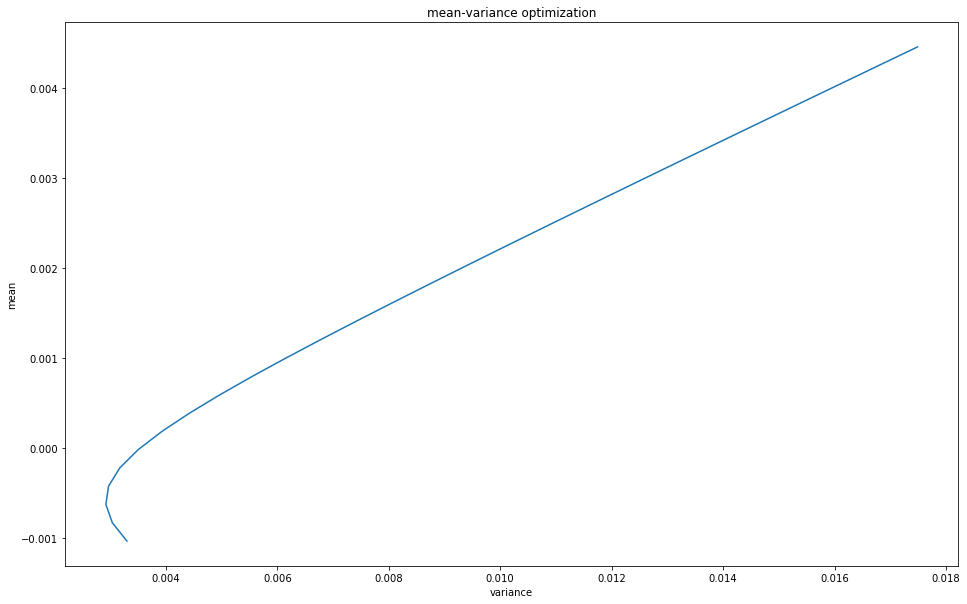

In [403]:
plt.figure(1, figsize=(16, 10))
plt.title("mean-variance optimization")
plt.xlabel("variance")
plt.ylabel("mean")
plt.plot(cov_grid, m_grid);

- to avoid using the mean return we can use risk parity model

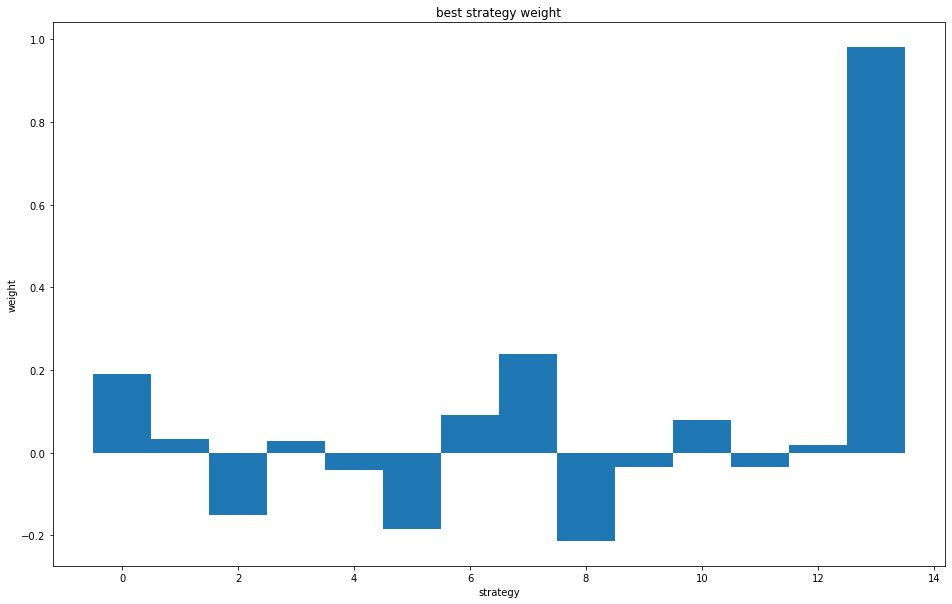

In [404]:
best_index = np.nanargmin(cov_grid)
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(best_weight.index.values, best_weight.values, width=1);

- we can see that there are some negative weights
- although we can do long and short for trading commodities
- here we optimize on the strategies, which we think are good in the training set
- so it does not make sense to short a good strategy
- we also find that there are some large positive and negative weight in magnitude
- it may lead to overfitting to the training data as well
- let's see how to avoid these

- at first  we try to use this without nonnegative constraint


- we construct the matrix to be used in quadratic programming

In [405]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return)).T
n_strat

14

In [406]:
# https://pypi.org/project/quadprog/
# pip install quadprog
# need to download visual studio before running
import quadprog as qp

In [407]:
m_grid[best_index]
# -0.00048162353986352154

-0.0006255463831703638

In [408]:
sol = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.array([1, m_grid[best_index]]), meq=2)
sol[0]

# array([-0.00346019,  0.0403798 , -0.0031523 ,  0.07341329,  0.00326   ,
#         0.02980065,  0.00631234,  0.03475584, -0.01382954, -0.00522846,
#         0.02575003,  0.02179153,  0.03358088,  0.00608251,  0.0046864 ,
#         0.01843479, -0.0440756 , -0.04796313, -0.04496317, -0.00657127,
#         0.79912547, -0.69959258,  0.02043746,  0.06377524,  0.68724999])

array([ 0.19063742,  0.03218948, -0.15020718,  0.02817864, -0.0412185 ,
       -0.18539446,  0.08986454,  0.23972128, -0.21410261, -0.03463654,
        0.07967539, -0.03383433,  0.01726312,  0.98186375])

In [409]:
sum(abs(sol[0] - best_weight) > 0.00001)

0

In [410]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)))).T
A_mat.shape

(14, 16)

In [411]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.zeros(n_strat))), meq=2)
sol_nneg[0]

array([ 5.47989047e-02,  2.46183733e-02, -4.42205587e-17,  1.65592630e-18,
        4.03375224e-18, -4.91634746e-17, -5.86551626e-19,  2.85012549e-02,
       -5.71933660e-17,  4.21851525e-02, -8.82066436e-18,  2.92164931e-18,
        0.00000000e+00,  8.49896315e-01])

- we can see that there are many tiny positive values due to rounding error
- so we can use a small positive number to avoid it

In [412]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.repeat(1e-5, n_strat))), meq=2)
sol_nneg[0]

# array([5.47750816e-02, 2.46252728e-02, 1.00000000e-05, 1.00000000e-05,
#        1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 2.84467390e-02,
#        1.00000000e-05, 4.22288725e-02, 1.00000000e-05, 1.00000000e-05,
#        1.00000000e-05, 8.49834034e-01])

array([5.47750816e-02, 2.46252728e-02, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 2.84467390e-02,
       1.00000000e-05, 4.22288725e-02, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 8.49834034e-01])

- however, now the problem is that there are too many 1e-5s, and the tenth strategy has portion of 0.59
- that may be overfitting to that strategy
- if it performs worse inthe testing samples our overall result would be very bad
- let's set a limit for the maximum portion of each strategy
- average strategy is 

- we can set maximum to be 10%
- but then we may not get the optimal mean values
- so we need to restart the whole optimization scheme again

In [413]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)), -np.diag(np.repeat(1, n_strat)))).T
cov_grid = np.repeat(np.nan, n_point)
for i in range(1, n_point-1):
    try:
        sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, 
                               b=np.hstack((1, m_grid[i], np.repeat(1e-5, n_strat), np.repeat(-0.1, n_strat))), meq=2)
    except ValueError:
        continue
    w = sol_nneg[0]
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w

In [414]:
best_index = np.nanargmin(cov_grid)
weight_grid[:, best_index]

# array([6.81680848e-02, 7.00000000e-02, 7.00000000e-02, 7.00000000e-02,
#        1.00000000e-05, 4.12230696e-02, 1.00000000e-05, 7.00000000e-02,
#        7.00000000e-02, 1.00000000e-05, 1.51036708e-02, 1.00000000e-05,
#        1.00000000e-05, 7.00000000e-02, 1.00000000e-05, 1.00000000e-05,
#        3.54151748e-02, 1.00000000e-05, 1.00000000e-05, 7.00000000e-02,
#        7.00000000e-02, 7.00000000e-02, 7.00000000e-02, 7.00000000e-02,
#        7.00000000e-02])

array([1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
       2.57871008e-02, 1.00000000e-01, 1.00000000e-05, 7.41828992e-02,
       1.00000000e-05, 1.00000000e-01, 1.00000000e-05, 1.00000000e-01,
       1.00000000e-01, 1.00000000e-01])

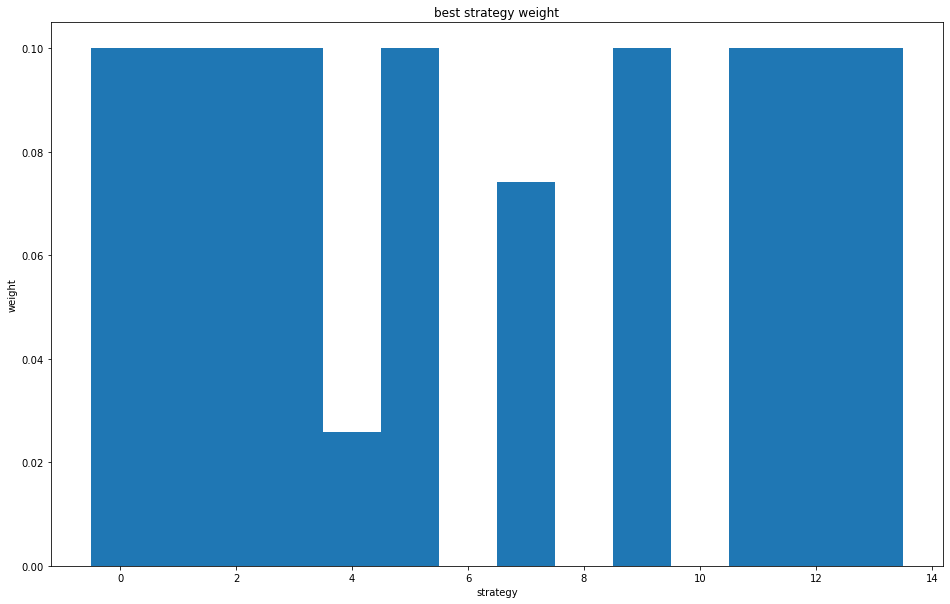

In [415]:
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(np.linspace(0, len(weight_grid)-1, len(weight_grid)), weight_grid[:, best_index], width=1);

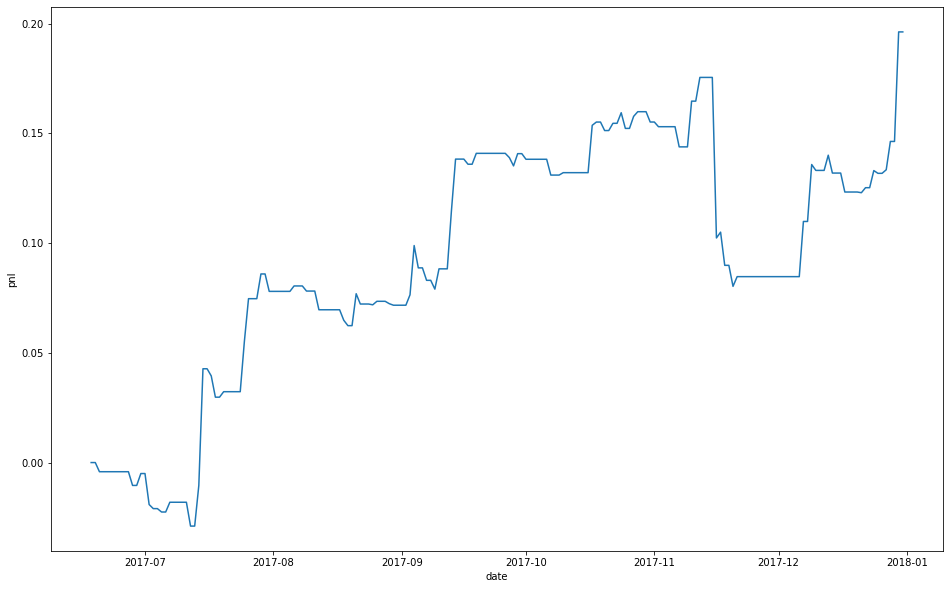

In [416]:
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
best_weight[best_weight<1.1e-5] = 0
train_pnl = np.dot(pnl_mat, best_weight)
train_pnl = pd.Series(train_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], train_pnl.cumsum());

In [417]:
sharpe(train_pnl)
## 1.3671973597434892

1.6338788813379423

In [418]:
print(chosen_strategy.keys())
test_pnl = np.dot(test_mat, best_weight)

dict_keys(['kdj.k.4096'])


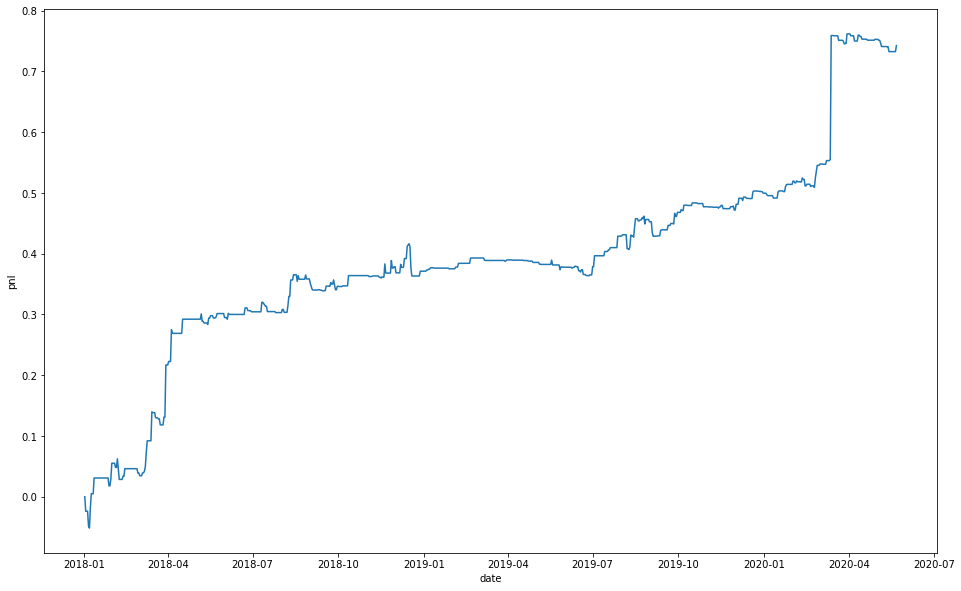

In [419]:
test_pnl = np.dot(test_mat, best_weight)
test_pnl = pd.Series(test_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][1:], test_pnl.cumsum());

In [420]:
sharpe(test_pnl)

# 1.8238896242305838


1.4679167219542606

In [421]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

In [422]:
from scipy.optimize import minimize
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)
    
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

- get weight of risk parity

In [423]:
parity_weight = risk_parity(pnl_mat)
parity_weight = pd.Series(parity_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3026
         Function evaluations: 4046


- plot the weight

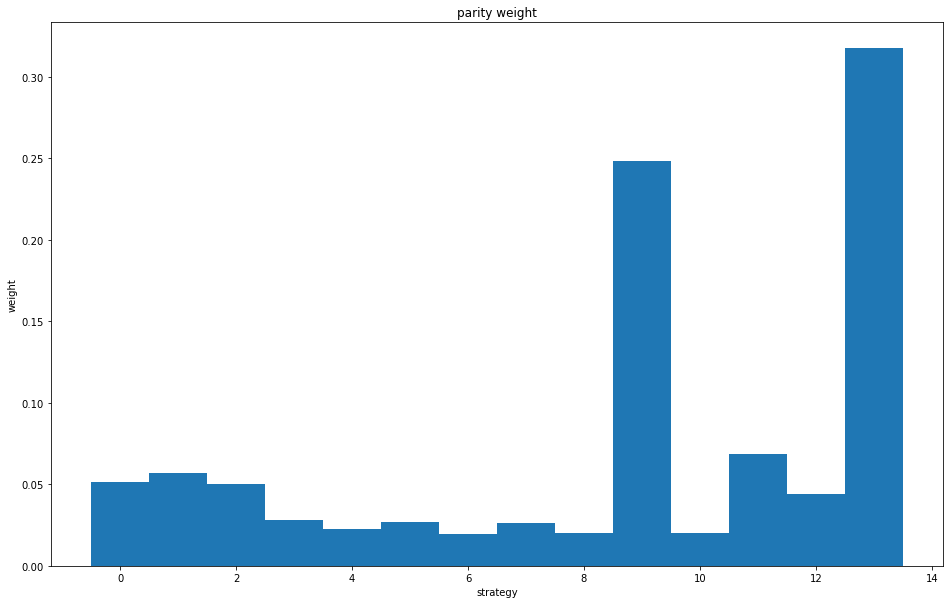

In [424]:
plt.figure(1, figsize=(16, 10))
plt.title("parity weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(parity_weight.index, parity_weight.values, width=1);

- check negative weight

In [425]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [426]:
train_parity = np.dot(pnl_mat, parity_weight)
train_parity = pd.Series(train_parity)

- and plot the final pnl

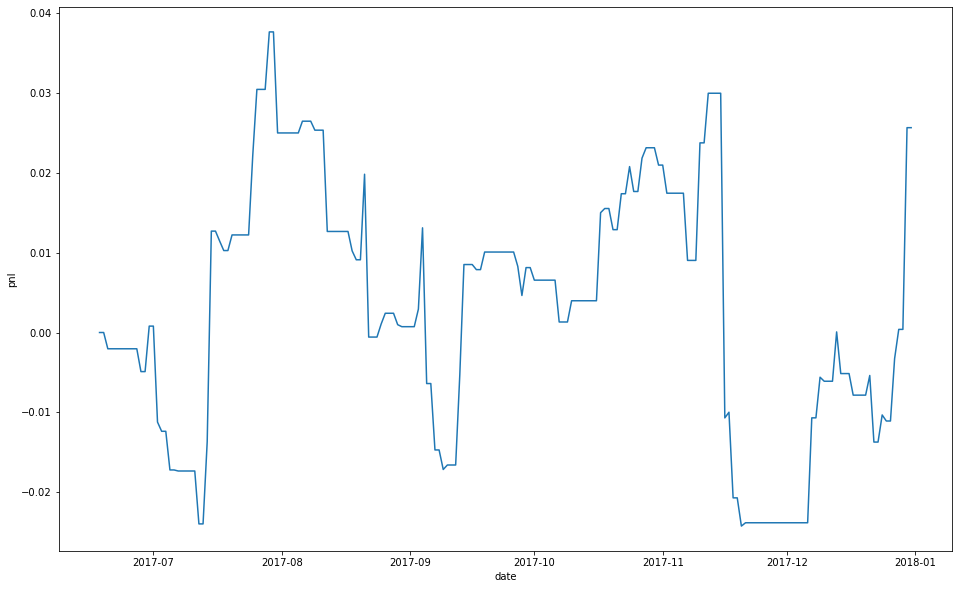

In [427]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], train_parity.cumsum());

- calculate the sharp ratio

In [428]:
sharpe(train_parity)
## 0.7336322221834293

0.3586790134620911

- now we check the performance on out-of-sample data

In [429]:
test_parity = np.dot(test_mat, parity_weight)
test_parity = pd.Series(test_parity)

- and plot the final pnl

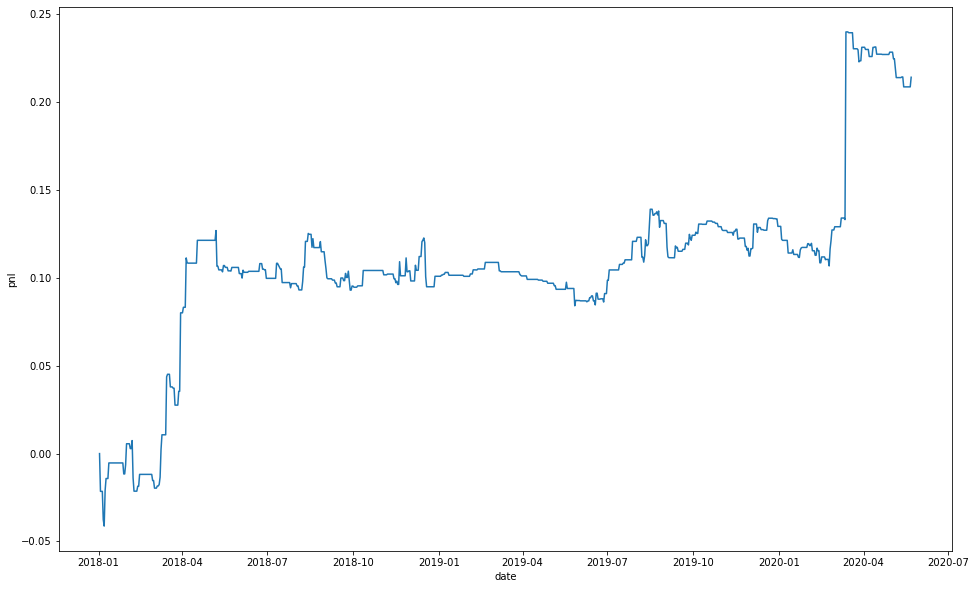

In [430]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][1:], test_parity.cumsum());

- calculate the sharp ratio

In [431]:
sharpe(test_parity)
## 0.9921561066464466
## it's also very similar to the average weight result

0.7550406057865036

- now we get back to the estimation of covariance matrix
- somebody claims that we can simply use diagonal values and set other zero
- let's try it

- get weight of risk parity

In [432]:
diagonal_weight = risk_parity(pnl_mat, only_diag=True)
diagonal_weight = pd.Series(diagonal_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2434
         Function evaluations: 3265


- plot the weight

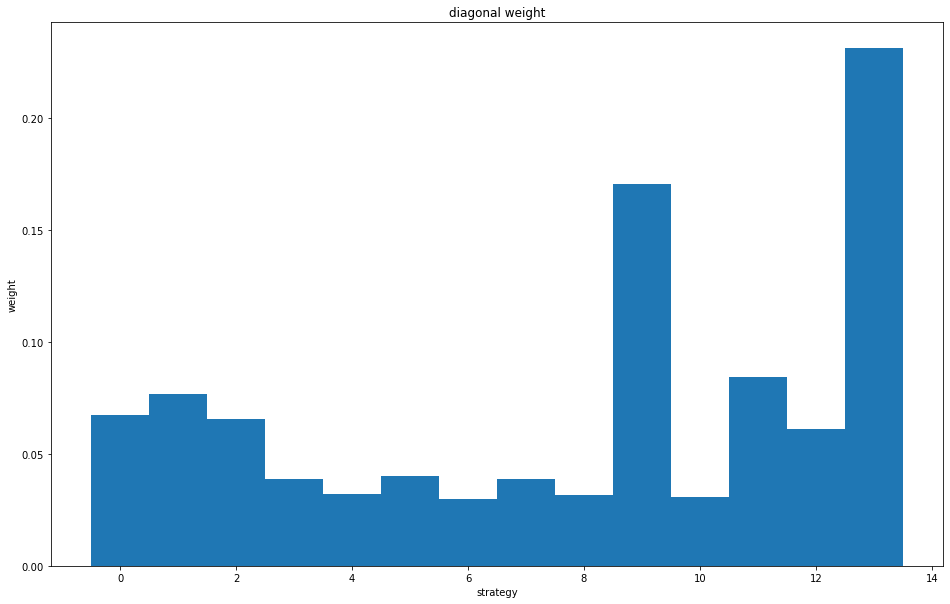

In [433]:
plt.figure(1, figsize=(16, 10))
plt.title("diagonal weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(diagonal_weight.index, diagonal_weight.values, width=1);

- check negative weight

In [434]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [435]:
train_diagonal = np.dot(pnl_mat, diagonal_weight)
train_diagonal = pd.Series(train_diagonal)

- and plot the final pnl

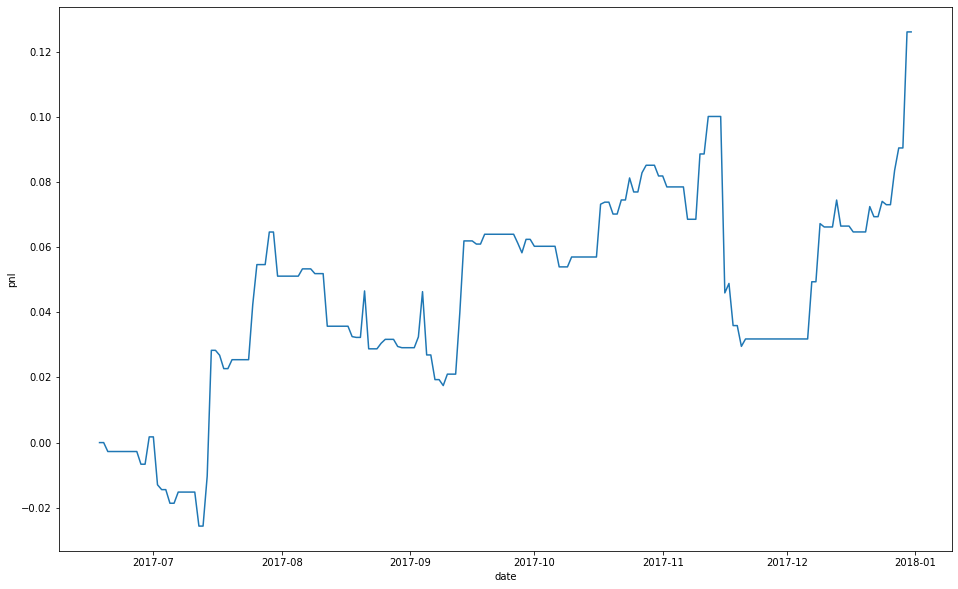

In [436]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], train_diagonal.cumsum());

- calculate the sharp ratio

In [437]:
sharpe(train_diagonal)
## 1.5718840147584823

1.310909295948608

- now we check the performance on out-of-sample data

In [438]:
test_diagonal = np.dot(test_mat, diagonal_weight)
test_diagonal = pd.Series(test_diagonal)

- and plot the final pnl

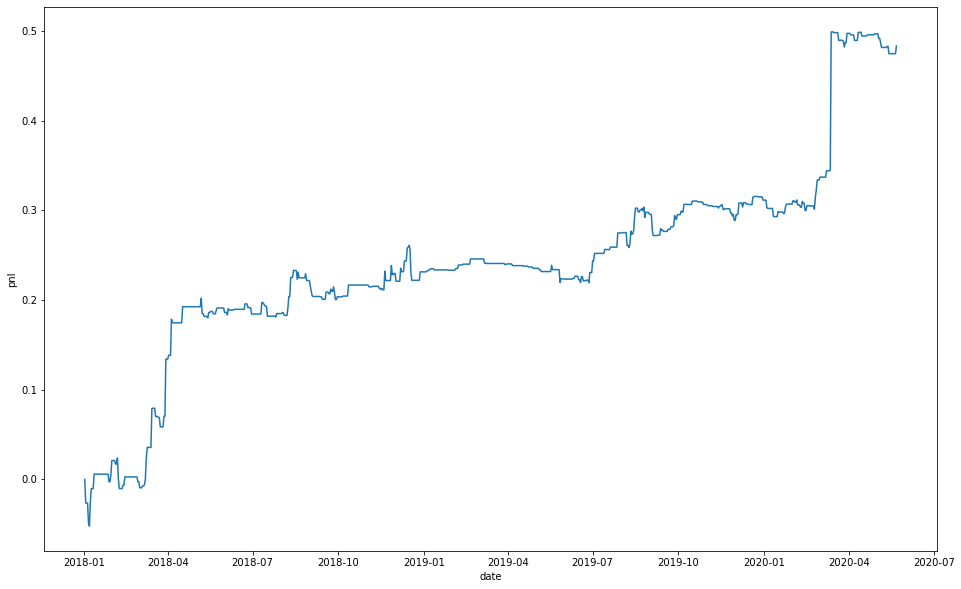

In [439]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][1:], test_diagonal.cumsum());

- calculate the sharp ratio

In [440]:
sharpe(test_diagonal)
## 1.4537546761119868

1.213451180224675

- now let's get the next weight: weight based on sharpe ratio

In [441]:
sharpe_mat = np.apply_along_axis(sharpe, 0, pnl_mat)
good_sharpe = sharpe_mat>0
sharpe_weight = zero_divide(sharpe_mat[good_sharpe], np.sum(sharpe_mat[good_sharpe]))
sharpe_weight = pd.Series(sharpe_weight)

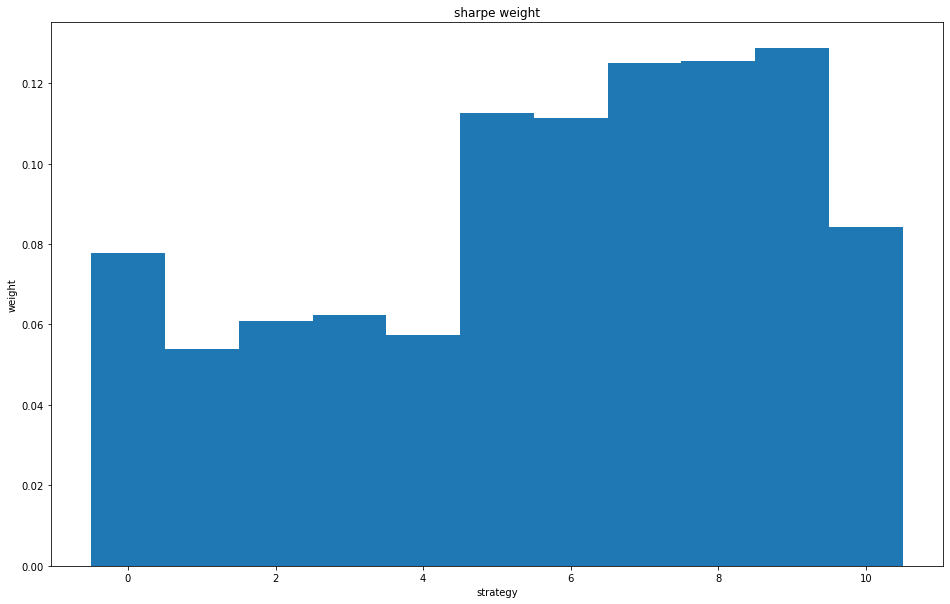

In [442]:
plt.figure(1, figsize=(16, 10))
plt.title("sharpe weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(sharpe_weight.index, sharpe_weight.values, width=1);

In [443]:
train_sharpe = np.dot(pnl_mat[:,good_sharpe], sharpe_weight)
train_sharpe = pd.Series(train_sharpe)

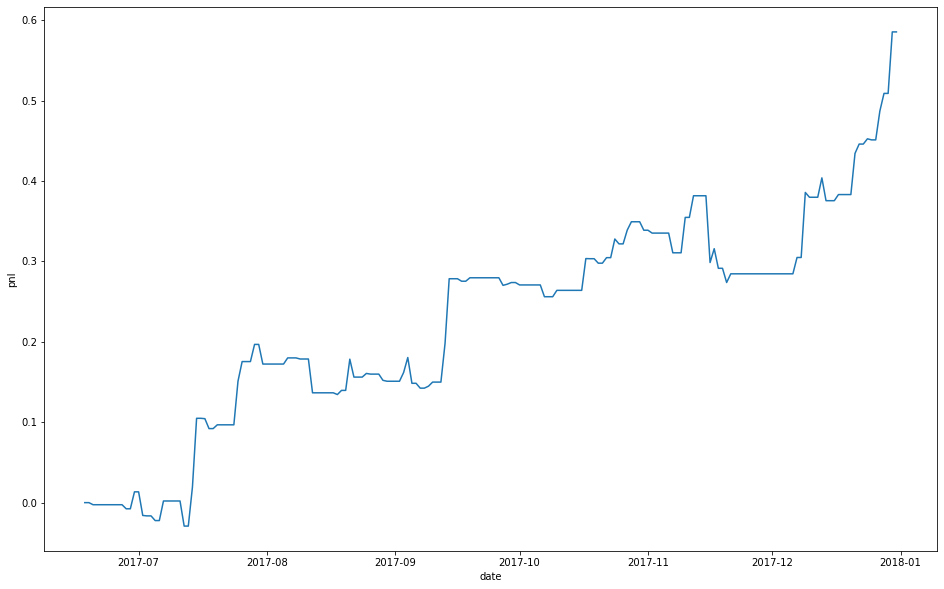

In [444]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], train_sharpe.cumsum());

In [445]:
sharpe(train_sharpe)
## 2.9229763569340346

2.6191900846183525

In [446]:
test_sharpe = np.dot(test_mat[:,good_sharpe], sharpe_weight)
test_sharpe = pd.Series(test_sharpe)

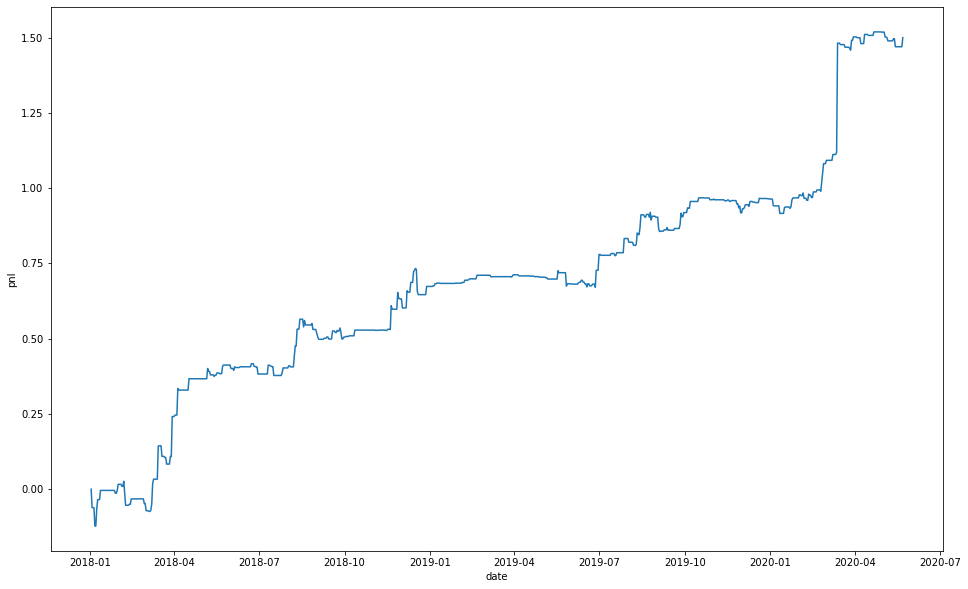

In [447]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][1:], test_sharpe.cumsum());

In [448]:
sharpe(test_sharpe)
## 1.2226701474567712

1.5616592748939417

- we can see that mean-variance performs the worst while avergage performs the best in pnl
- risk parity performs best when consider test sharpe ratio
- generally we can use risk parity in the future
- The last part we go to PCA

In [449]:
 from sklearn.decomposition import PCA

In [450]:
pca = PCA(n_components=0.95)
pca.fit(pnl_mat)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [451]:
rotation = pca.components_.transpose()
rotation

array([[ 9.42922451e-02,  2.54794713e-01, -2.93398941e-01,
        -3.77629832e-01, -1.86135835e-01,  1.19063012e-01],
       [ 9.07279579e-02,  1.96223555e-01, -2.84766462e-01,
        -2.80496497e-01, -1.41608243e-01, -1.34442690e-01],
       [ 9.77989818e-02,  2.62601802e-01, -3.04250490e-01,
        -3.86948826e-01, -3.08270206e-01, -3.95529415e-02],
       [ 2.76410958e-01,  4.69223135e-01,  1.97755172e-01,
         2.55511195e-01,  1.72305359e-01, -6.12649571e-01],
       [ 3.39476329e-01,  5.80552419e-01,  3.70525806e-01,
         1.40461494e-01, -8.76830311e-02,  5.43673550e-01],
       [ 2.92517437e-01, -1.21715130e-01, -4.40900889e-01,
         3.84023090e-01,  3.34073656e-02,  3.14078510e-01],
       [ 4.48374605e-01, -2.97171398e-01,  1.68558973e-01,
        -1.72887236e-01, -1.96806237e-02,  9.95603847e-02],
       [ 3.13156510e-01, -8.58858104e-02, -4.16815051e-01,
         4.41821869e-01, -9.40665562e-02, -2.66814015e-02],
       [ 4.25639289e-01, -2.65503495e-01,  1.306

In [452]:
train_pca = np.mean(np.matmul(pnl_mat,rotation), axis=1)

In [453]:
sharpe(train_pca)
## 2.940597252467745

1.1605008991377634

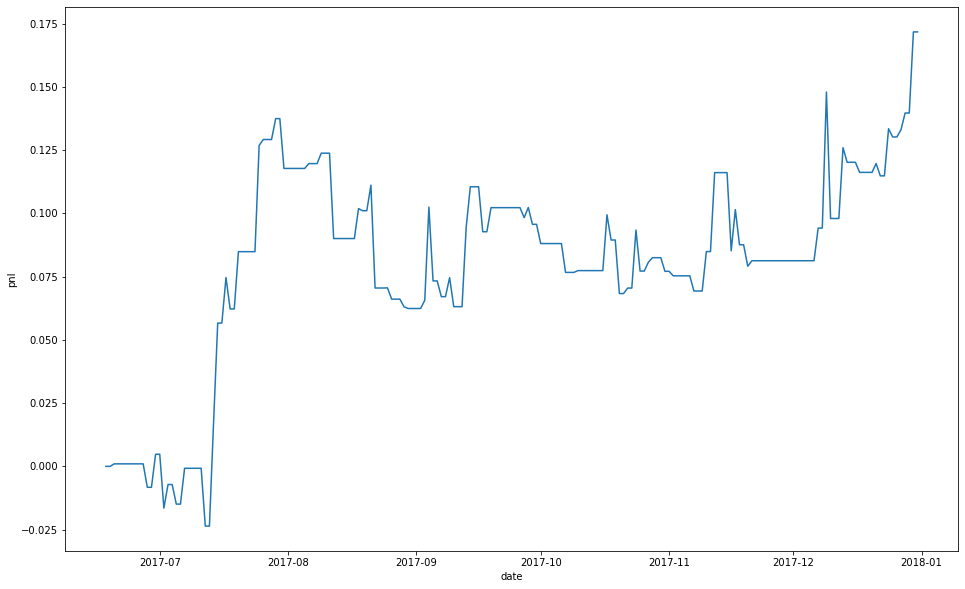

In [454]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample][1:], train_pca.cumsum())

In [455]:
test_pca = np.mean(np.matmul(test_mat,rotation), axis=1)

In [456]:
sharpe(test_pca)
## 1.5199558420127284

0.816429715722839

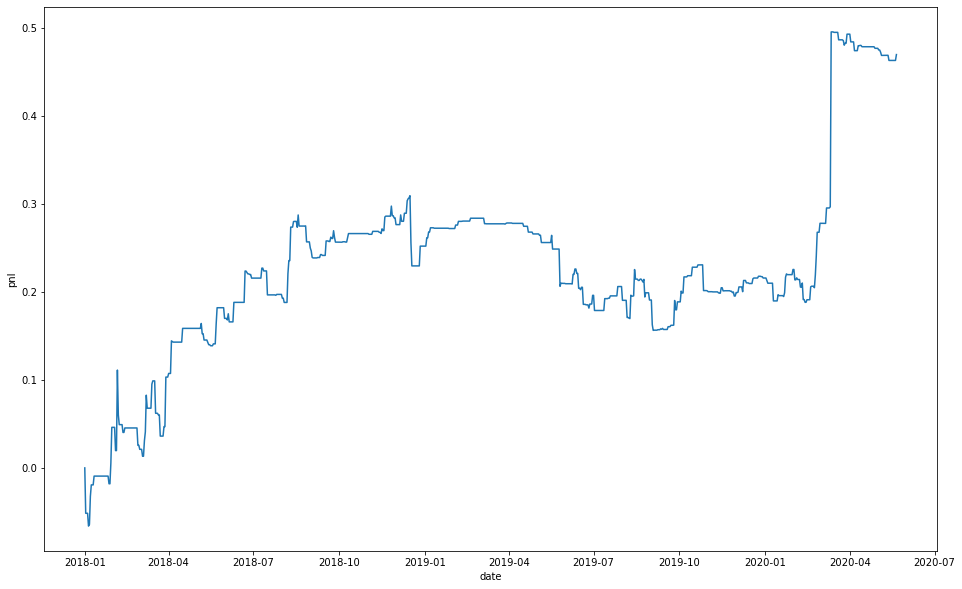

In [457]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][:-1], test_pca.cumsum());

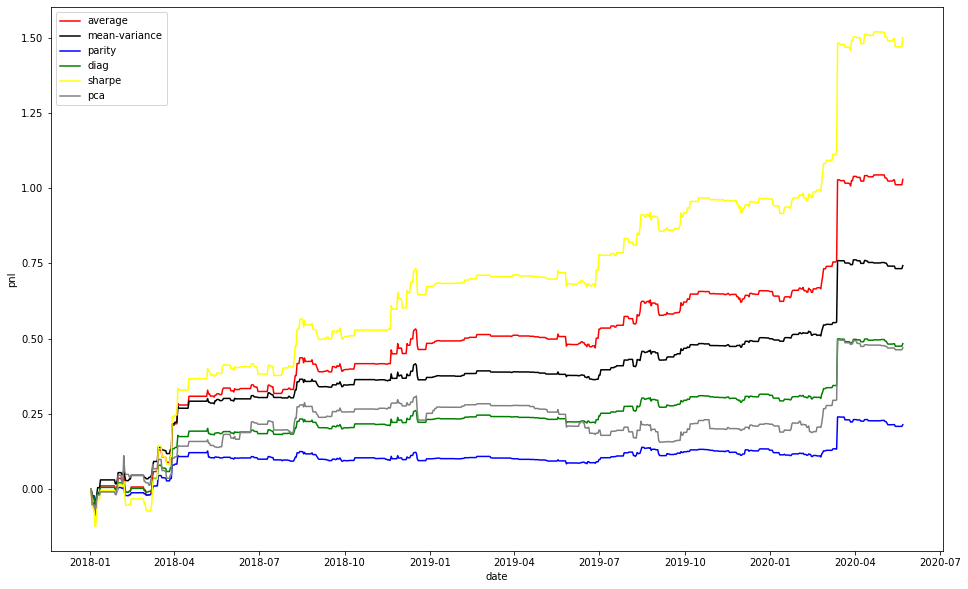

In [458]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
avg_plot, = plt.plot(format_dates[test_sample][1:], avg_test_pnl.cumsum(), color="red", label="average");
mean_plot, = plt.plot(format_dates[test_sample][1:], test_pnl.cumsum(), color="black", label="mean-variance");
parity_plot, = plt.plot(format_dates[test_sample][1:], test_parity.cumsum(), color="blue", label="parity");
diag_plot, = plt.plot(format_dates[test_sample][1:], test_diagonal.cumsum(), color="green", label="diag");
sharpe_plot, = plt.plot(format_dates[test_sample][1:], test_sharpe.cumsum(), color="yellow", label="sharpe");
pca_plot, = plt.plot(format_dates[test_sample][1:], test_pca.cumsum(), color="grey", label="pca");
plt.legend(handles=[avg_plot, mean_plot,parity_plot, diag_plot, sharpe_plot, pca_plot])